In [1]:
# Data stuff
import numpy as np
import pandas as pd
import dask.dataframe as dd

# Visual stuff
from IPython.display import display
# Configs 
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Random state seed
rand_state=42

# ML stuff
import sklearn
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import shap

# Dask
from dask.distributed import Client
client = Client()  # start distributed scheduler locally.  Launch dashboard

# Imbalanced learn 
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTENC

Using TensorFlow backend.


# Prepa data-set for models

In [2]:
# Import and display data-set
dataset = dd.read_csv('../data_gen/dataset_KNN_entire/*.part')
# Ensure correct types
dataset = dataset.astype(dtype={
    'gender':int,
    'ethnicity_AMERICAN INDIAN/ALASKA NATIVE':int,
    'ethnicity_ASIAN':int,
    'ethnicity_BLACK/AFRICAN AMERICAN':int,
    'ethnicity_HISPANIC/LATINO':int,
    'ethnicity_WHITE':int,
    'insurance_Medicaid':int,
    'insurance_Medicare':int,
    'marital_status_DIVORCED':int,
    'marital_status_MARRIED':int,
    'marital_status_SINGLE':int,
    'marital_status_WIDOWED':int,
    'language_english':int,
    'hospital_expire_flag':int,
})
# Order ints(categorical variables) and floats(number variables)
dataset = dataset[[
 'ethnicity_AMERICAN INDIAN/ALASKA NATIVE',
 'ethnicity_ASIAN',
 'ethnicity_BLACK/AFRICAN AMERICAN',
 'ethnicity_HISPANIC/LATINO',
 'ethnicity_WHITE',
 'insurance_Medicaid',
 'insurance_Medicare',
 'marital_status_DIVORCED',
 'marital_status_MARRIED',
 'marital_status_SINGLE',
 'marital_status_WIDOWED',
 'gender',
 'language_english',
 'hospital_expire_flag',
 'age_at_admission',
 'seq_num',
 'times_prev_admitted',
 'length_of_stay(days)',
 'BMI',
 'Glucose',
 'Potassium',
 'Sodium',
 'Chloride',
 'Bicarbonate',
 'Anion Gap',
 'Creatinine',
 'Urea Nitrogen',
 'Magnesium',
 'Hematocrit',
 'Hemoglobin',
 'Platelet Count',
 'Phosphate',
 'Calcium, Total',
 'White Blood Cells',
 'Red Blood Cells',
 'MCH',
 'RDW',
 'MCV',
 'pH',
 'PTT',
 'PT',
 'H'
]].compute()

In [3]:
# Generate data set withouth categories(all numbers)
Y_no_cat = dataset.hospital_expire_flag.values
X_no_cat = dataset.drop(columns=['hospital_expire_flag']).values

# dataset as is, but target variable dropped(hospital expire flag)
dataset_no_target = dataset.drop(columns=['hospital_expire_flag'])

# Feture names and categorical feature names
feature_names = dataset_no_target.select_dtypes(include='int').columns.values.tolist() + dataset_no_target.select_dtypes(exclude='int').columns.values.tolist() 
cat_feature_names = dataset_no_target.select_dtypes(include='int').columns.values.tolist() 

# Generate data set with categories(int type required)
dataframe_int_list = dataset_no_target.select_dtypes(include='int').values.tolist()
dataframe_no_int_list = dataset_no_target.select_dtypes(exclude='int').values.tolist()
Y = dataset.hospital_expire_flag.values.tolist()
X = []
for i,v in enumerate(dataframe_int_list):
    X = X + [v+dataframe_no_int_list[i]]

# Generate categorical feature indicies
cat_features_indices=list(range(0,len(dataframe_int_list[0])))

# Define functions and variables

In [4]:
# Function that w
def strat_cv_it(classifier, params, uses_cat, param_comb ):
    folds = 3
    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = rand_state)
    
    imba_pipeline = make_pipeline(SMOTENC(random_state=42,categorical_features=cat_features_indices), 
                                 classifier)
    
    # Perform fit and scoring
    if uses_cat:
        random_search = RandomizedSearchCV(imba_pipeline, return_train_score=True, param_distributions=params ,scoring='roc_auc', n_iter=param_comb, n_jobs=4, cv=skf.split(X, Y),random_state = rand_state, refit=True, verbose=3,  )
        random_search.fit(X, Y)     
    else:
        random_search = RandomizedSearchCV(imba_pipeline, return_train_score=True, param_distributions=params ,scoring='roc_auc', n_iter=param_comb, n_jobs=4, cv=skf.split(X_no_cat, Y_no_cat),random_state = rand_state, refit=True, verbose=3)
        random_search.fit(X_no_cat, Y_no_cat)
    
    # Display results and return best model
    display(random_search.best_score_)
    display(random_search.best_params_)
    display(pd.DataFrame(random_search.cv_results_))
    return random_search.best_estimator_

# Models

## Random Forest

In [5]:
RF_classifier =  RandomForestClassifier(class_weight='balanced')
RF_params = {
        'randomforestclassifier__max_depth': (3,4,5,6,7,10,15,20,25),
        'randomforestclassifier__n_estimators': (1,5,10,25,50,100),
        'randomforestclassifier__criterion':['gini','entropy'],
        'randomforestclassifier__max_features': ['auto', 'sqrt'],
        'randomforestclassifier__min_samples_leaf': [1, 2, 4],
        'randomforestclassifier__min_samples_split': [2, 5, 10],
        'randomforestclassifier__bootstrap': [False,True],
        'randomforestclassifier__class_weight':[None,'balanced_subsample','balanced']
}
model = strat_cv_it(RF_classifier ,RF_params,False, 50)
explainer = shap.TreeExplainer(model['randomforestclassifier'])

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   39.3s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:  3.6min finished


0.8029995281426466

{'randomforestclassifier__n_estimators': 100,
 'randomforestclassifier__min_samples_split': 5,
 'randomforestclassifier__min_samples_leaf': 4,
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__max_depth': 20,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__class_weight': 'balanced_subsample',
 'randomforestclassifier__bootstrap': False}

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        5.466709      0.026088         0.035904    2.154388e-03   
1        3.965392      0.042384         0.014628    4.702465e-04   
2        3.657216      0.011828         0.009641    4.700217e-04   
3        3.242659      0.018013         0.007314    4.701903e-04   
4        6.422153      0.018324         0.043883    8.141987e-04   
5       11.246248      0.083888         0.063165    2.860102e-03   
6        3.071782      0.041554         0.006981    3.893359e-07   
7        5.684460      0.060907         0.033910    8.141015e-04   
8        5.714380      0.056426         0.034242    9.402119e-04   
9       10.369593      0.050543         0.053856    8.146856e-04   
10       4.016255      0.132018         0.013963    1.946680e-07   
11      12.143846      0.019651         0.103723    8.145881e-04   
12       7.303129      0.016293         0.058510    2.488098e-03   
13       2.949775      0.012624         0.003990    5.150430e-07   
14      17.235891      0.093135         0.110704    1.628689e-03   
15       3.458414      0.034781         0.009309    4.700779e-04   
16      10.035819      0.062535         0.108377    3.083595e-03   
17       3.036211      0.030797         0.006317    4.698533e-04   
18       4.286532      0.030513         0.018284    4.705837e-04   
19       3.272578      0.013561         0.006649    4.704151e-04   
20       7.409512      0.027571         0.049534    1.695295e-03   
21       2.952435      0.010182         0.003990    4.495664e-07   
22       3.397245      0.013852         0.008644    4.703026e-04   
23       3.471048      0.018396         0.008643    4.701341e-04   
24       3.281554      0.023606         0.006649    4.702466e-04   
25       2.956757      0.024971         0.003989    1.123916e-07   
26       3.346049      0.009873         0.009308    4.704714e-04   
27       3.694782      0.013683         0.014627    4.703026e-04   
28       5.731666      0.010007         0.033910    1.946680e-07   
29       3.674836      0.027281         0.011968    2.247832e-07   
30       2.984682      0.009261         0.005984    1.123916e-07   
31       3.008285      0.021581         0.005319    4.700779e-04   
32      14.368562      0.106058         0.119680    9.176659e-03   
33       7.829056      0.030933         0.060173    2.617363e-03   
34       3.190797      0.024502         0.009974    1.410627e-03   
35       3.698107      0.009391         0.015625    4.702464e-04   
36       8.717679      0.070183         0.061835    1.409896e-03   
37       6.340039      0.004071         0.045545    1.243582e-03   
38       4.087731      0.073345         0.015625    4.701340e-04   
39       7.100006      0.054407         0.033245    1.243773e-03   
40       2.976371      0.026328         0.004322    4.701341e-04   
41       3.185811      0.037989         0.006649    4.704150e-04   
42       8.229983      0.038780         0.044215    4.700779e-04   
43       3.023910      0.004534         0.004322    4.704151e-04   
44       8.326391      0.026328         0.044548    9.397061e-04   
45       3.105692      0.037379         0.007979    2.973602e-07   
46       2.928499      0.014665         0.003657    4.703588e-04   
47       5.128945      0.013438         0.031915    1.410290e-03   
48      11.596311      0.287259         0.063511    2.477904e-03   
49       3.752960      0.367113         0.011968    4.231319e-03   

   param_randomforestclassifier__n_estimators  \
0                                          50   
1                                          10   
2                                          10   
3                                           5   
4                                          50   
5                                          50   
6                                           5   
7                                          50   
8                                          50   
9                                          50

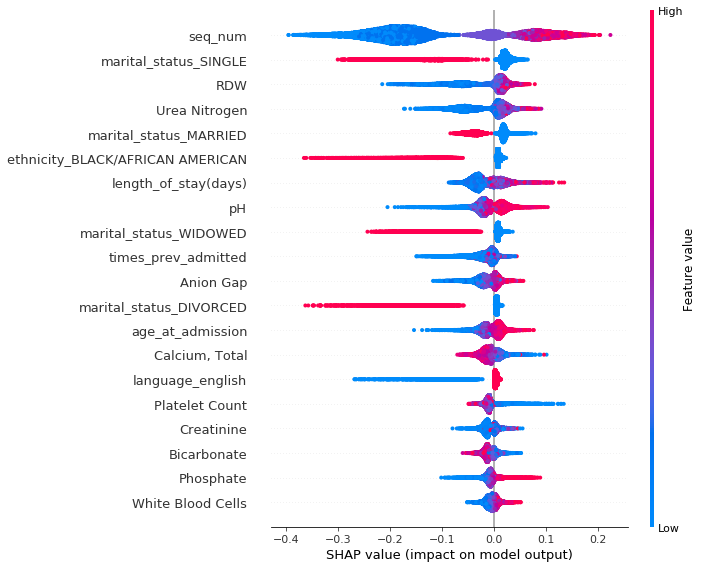

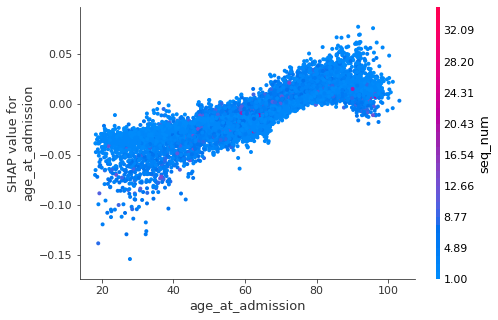

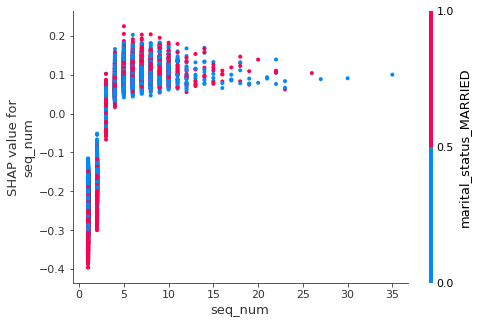

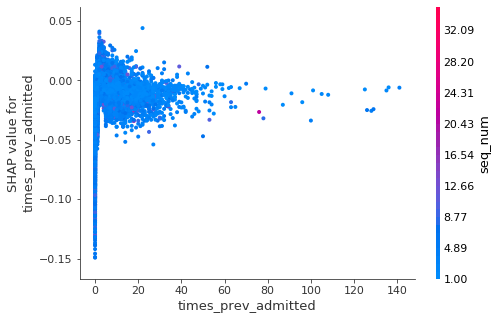

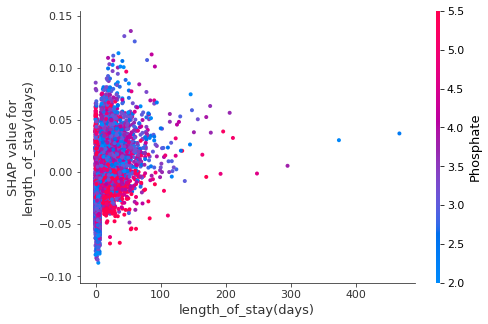

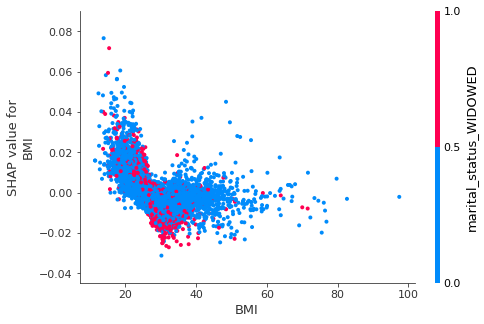

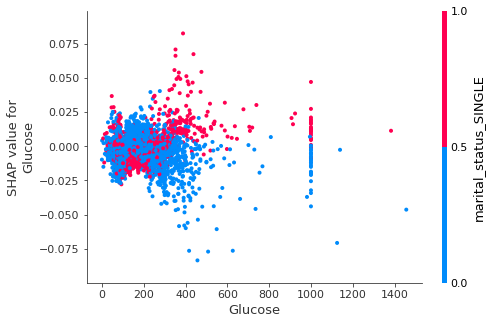

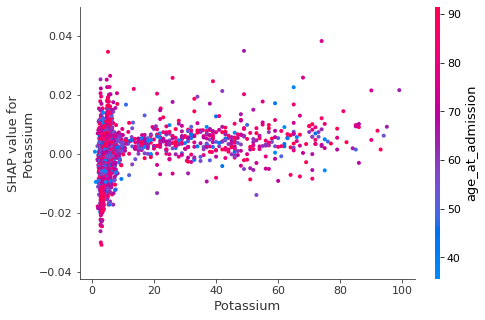

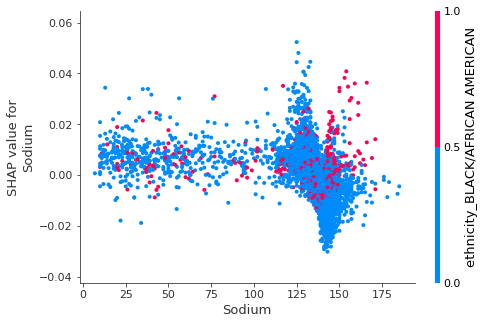

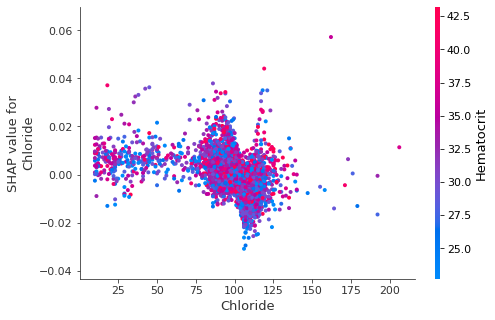

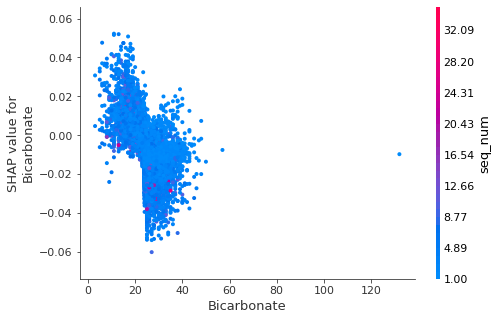

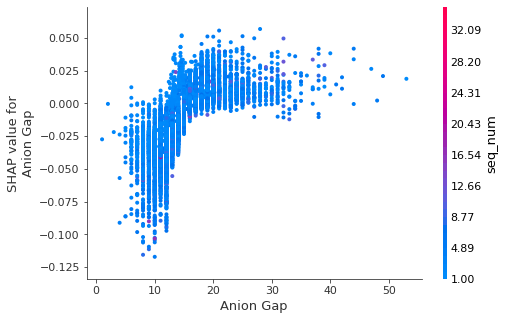

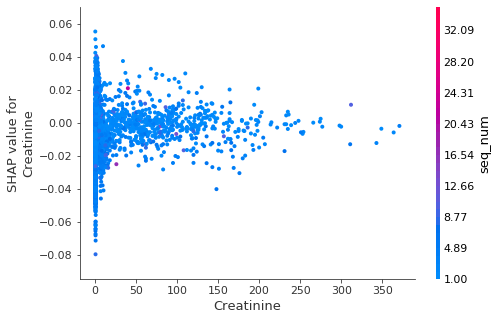

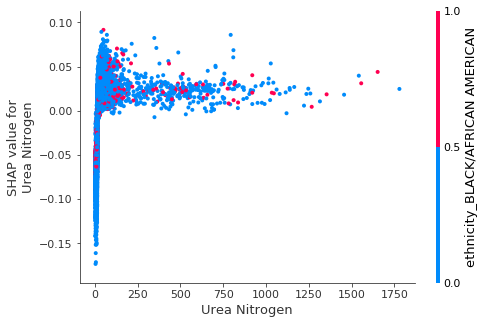

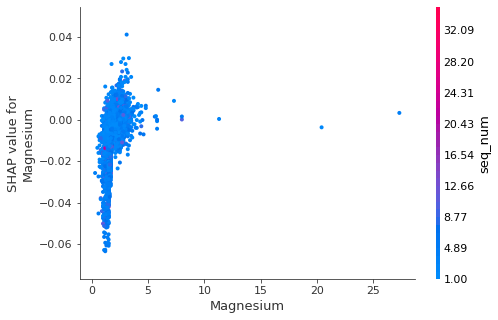

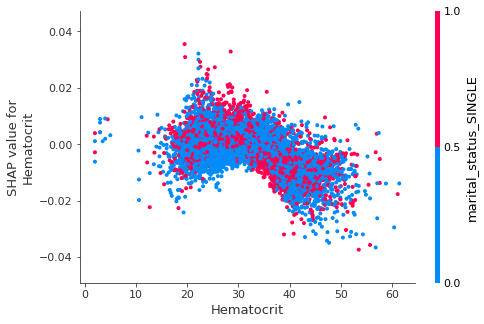

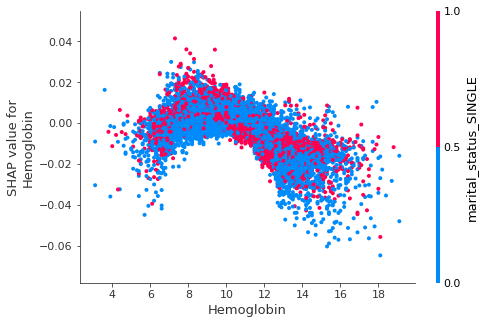

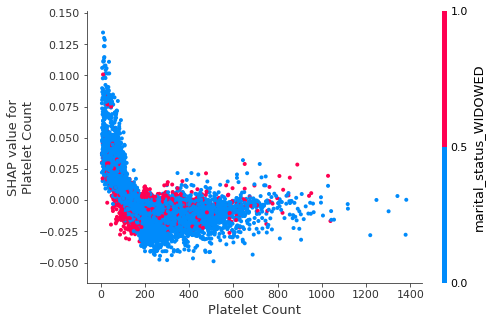

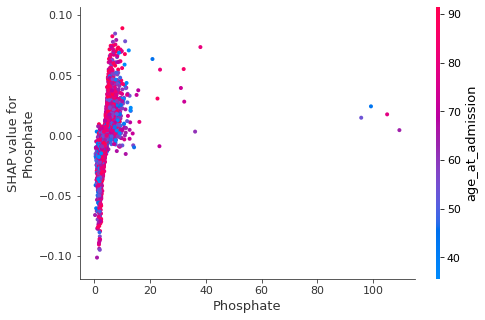

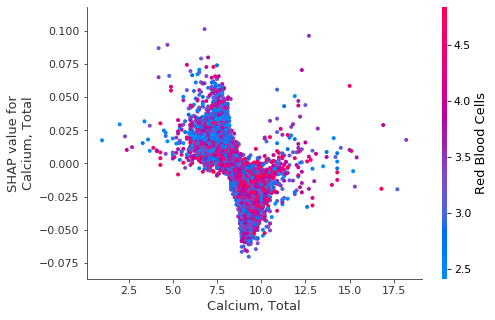

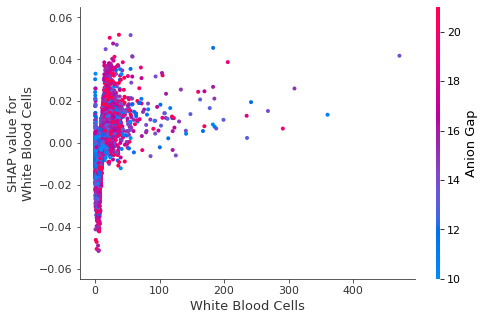

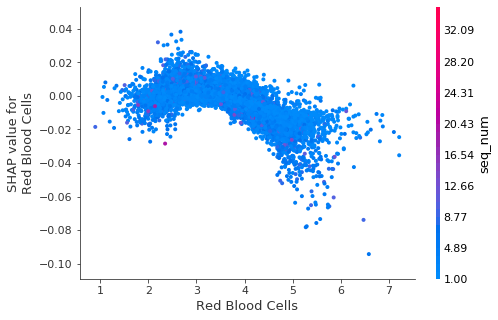

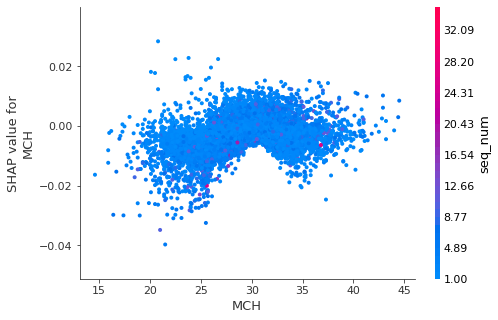

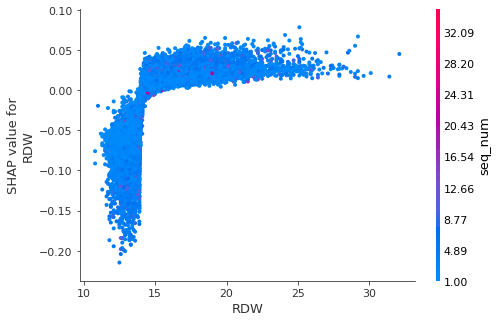

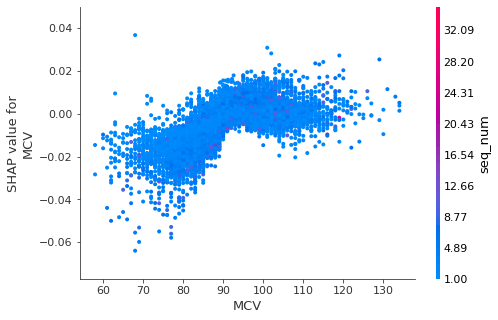

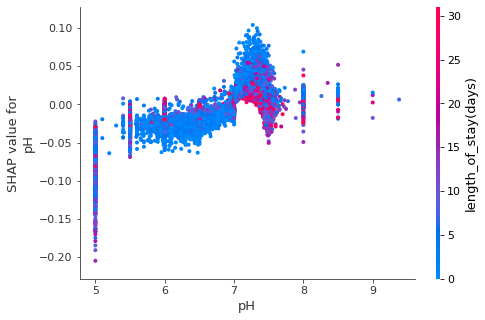

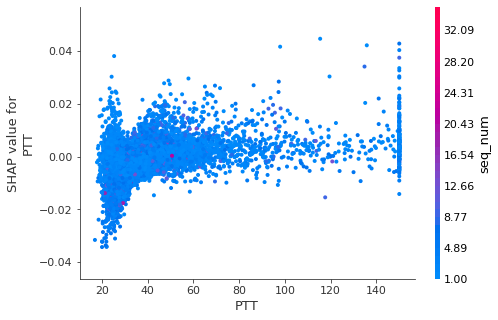

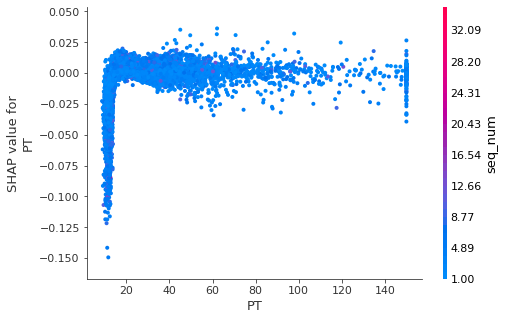

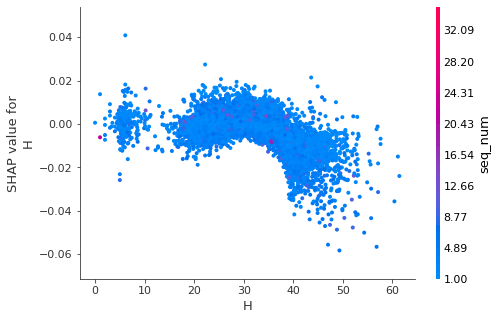

In [6]:
shap_values = explainer.shap_values( X_no_cat)
shap.summary_plot(shap_values[1],X_no_cat ,feature_names=feature_names)
for predictor in feature_names:
    if predictor not in cat_feature_names:
        shap.dependence_plot(predictor, shap_values[1],X_no_cat ,feature_names=feature_names)

## XGBOOST

In [7]:
xgb_classifier = xgb.XGBClassifier(objective = "binary:logistic",random_state=rand_state)
xgb_params = { 
        'xgbclassifier__learning_rate': (0.01, 0.05,0.1),
        'xgbclassifier__min_child_weight': [3, 5, 10],
        'xgbclassifier__gamma': [0.5, 1.5, 2, 5],
        'xgbclassifier__subsample': [0.6, 0.8, 1.0],
        'xgbclassifier__colsample_bytree': [0.6, 0.8, 1.0],
        'xgbclassifier__max_depth': list(range(5,30)),
        'xgbclassifier__scale_pos_weight': [0.5,0.75,0.9,1, 1.1, 1.25,1.5]
}
model = strat_cv_it(xgb_classifier ,xgb_params,False,50)['xgbclassifier']
explainer = shap.TreeExplainer(model)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  7.3min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:  8.9min finished


0.8227828307092936

{'xgbclassifier__subsample': 1.0,
 'xgbclassifier__scale_pos_weight': 1.1,
 'xgbclassifier__min_child_weight': 5,
 'xgbclassifier__max_depth': 22,
 'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__gamma': 5,
 'xgbclassifier__colsample_bytree': 0.6}

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       22.157059      0.081388         0.081116    3.291163e-03   
1        6.916165      0.255597         0.036236    4.701903e-04   
2       15.112238      0.068815         0.113032    2.049086e-03   
3       13.676081      0.129306         0.050199    1.695155e-03   
4       19.882810      0.099177         0.081449    1.243773e-03   
5       19.349237      0.050802         0.081781    2.936175e-03   
6       10.109289      0.111702         0.072140    4.700779e-04   
7       22.834912      0.119189         0.081449    1.243879e-03   
8       15.091959      0.146256         0.092087    9.403805e-04   
9       15.268156      0.069633         0.079121    4.016294e-03   
10      15.760172      0.052656         0.064162    9.399872e-04   
11      18.569324      0.106635         0.099068    1.694796e-03   
12      21.959588      0.241336         0.092420    1.694937e-03   
13       8.939086      0.046115         0.047207    3.083098e-03   
14       9.626248      0.072255         0.051196    1.244028e-03   
15      11.243257      0.083143         0.057843    8.142995e-04   
16       7.405854      0.012005         0.048537    2.350951e-03   
17      14.543760      0.138255         0.108377    1.244028e-03   
18      21.179674      0.248455         0.073803    8.140041e-04   
19      13.740243      0.133287         0.095744    2.247832e-07   
20      13.689710      0.079305         0.105385    1.880873e-03   
21       8.935762      0.091180         0.030585    1.244134e-03   
22      20.752816      0.040441         0.073470    3.671958e-03   
23       8.824060      0.041236         0.056516    1.244304e-03   
24      11.261540      0.049736         0.053856    2.821085e-03   
25      15.765158      0.155729         0.079122    2.617384e-03   
26      12.421437      0.053846         0.071143    4.699094e-04   
27       7.602661      0.020794         0.047540    4.703589e-04   
28      15.995210      0.037565         0.091089    2.049306e-03   
29      15.197344      0.006958         0.067486    2.049164e-03   
30      14.853265      0.056810         0.092420    2.487800e-03   
31       7.726996      0.021427         0.031249    4.702464e-04   
32      15.707646      0.020233         0.077791    1.628008e-03   
33      15.230256      0.075468         0.116355    1.448303e-02   
34       8.993939      0.044520         0.058177    4.700217e-04   
35      10.642862      0.050634         0.059182    4.780343e-03   
36      15.830983      0.008553         0.068816    2.154388e-03   
37      13.886185      0.056066         0.064826    8.143934e-04   
38      10.626240      0.060623         0.079454    1.244070e-03   
39      15.783443      0.163135         0.107047    2.487800e-03   
40       7.702727      0.008238         0.041556    1.695046e-03   
41      13.565709      0.162898         0.067486    4.697969e-04   
42      10.058093      0.080040         0.071808    5.699822e-03   
43      11.332018      0.025859         0.084441    4.630529e-03   
44      12.735597      0.069957         0.086103    1.243985e-03   
45      19.045716      0.057381         0.090092    1.243709e-03   
46      16.152456      0.137381         0.085438    2.617747e-03   
47      10.575043      0.019103         0.071143    2.350783e-03   
48      13.616573      0.111642         0.071143    2.859538e-03   
49      12.531143      0.184278         0.062839    8.059398e-04   

   param_xgbclassifier__subsample param_xgbclassifier__scale_pos_weight  \
0                             0.8                                  1.25   
1                             0.6                                  0.75   
2                               1                                   1.5   
3                             0.8                                   0.5   
4                             0.8                                  1.25   
5                               1                                   0.5   
6         

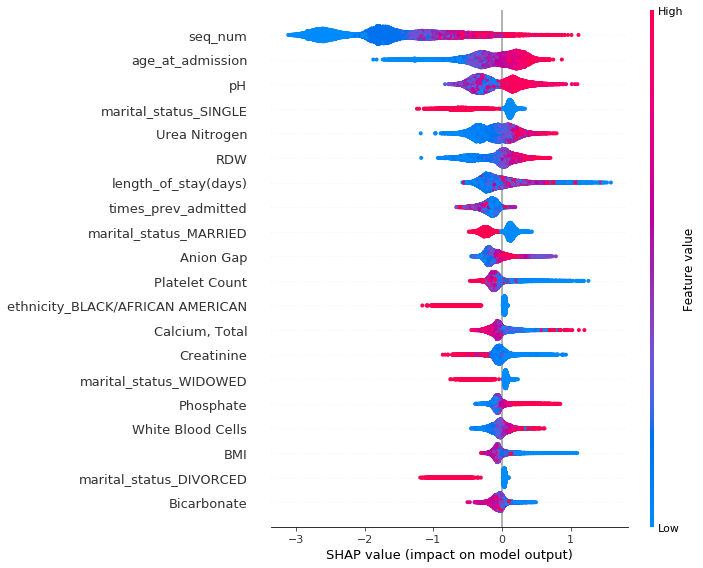

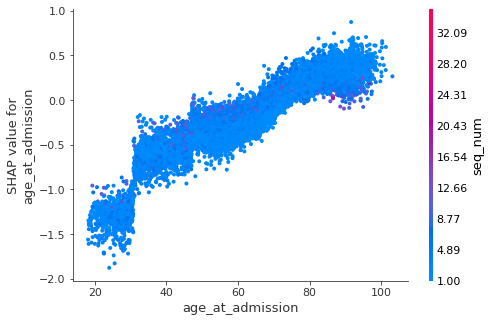

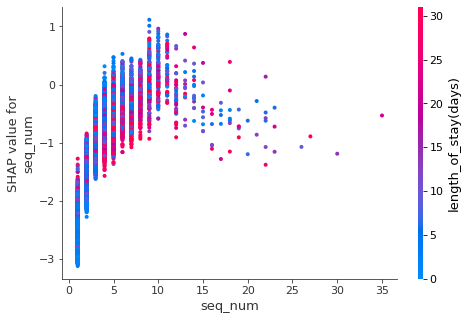

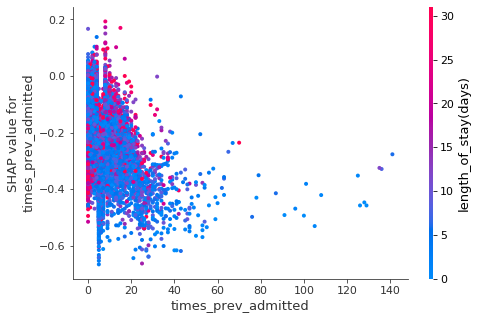

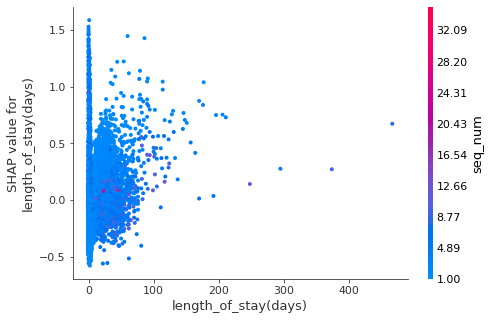

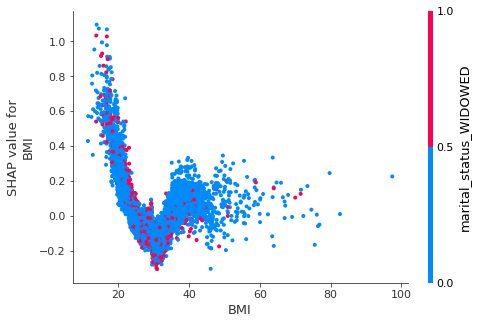

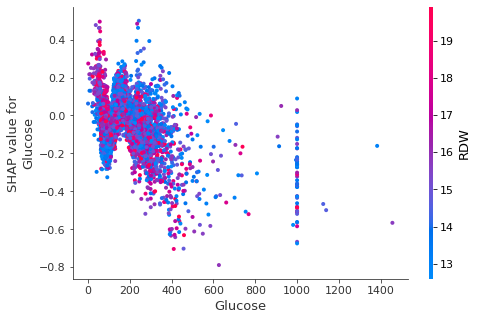

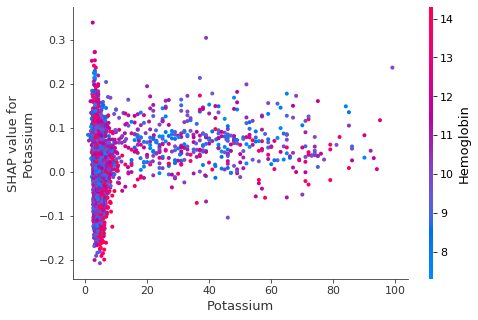

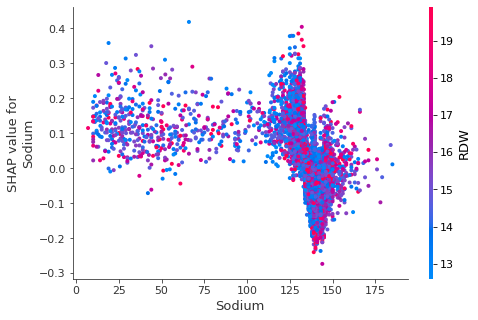

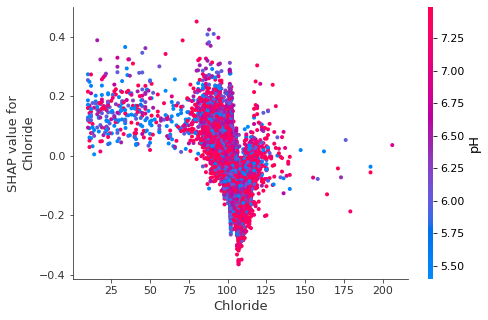

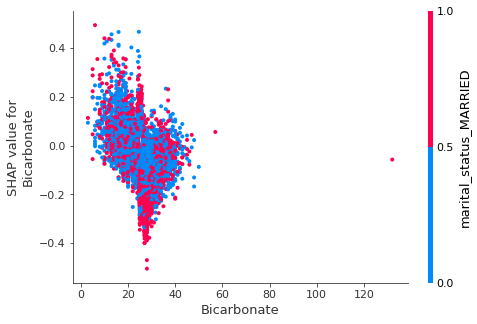

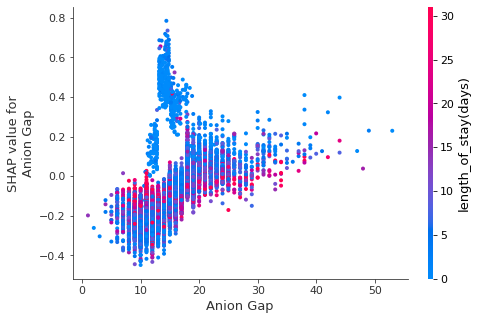

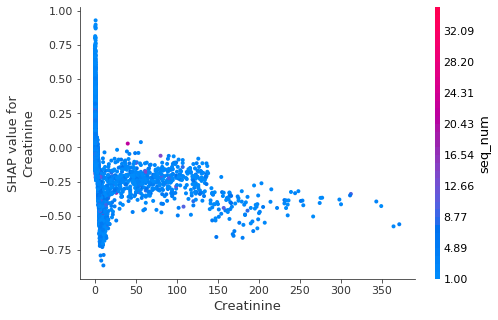

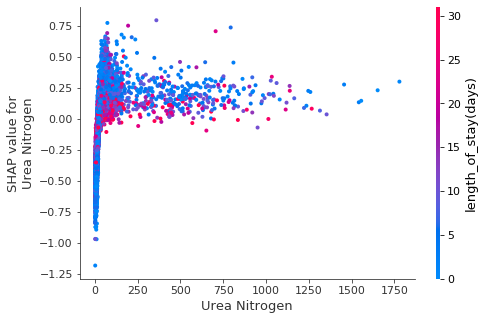

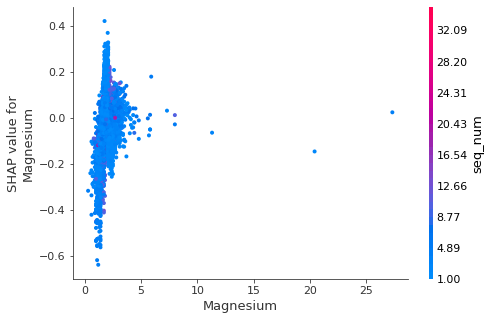

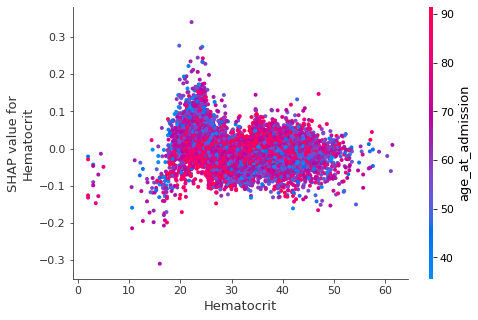

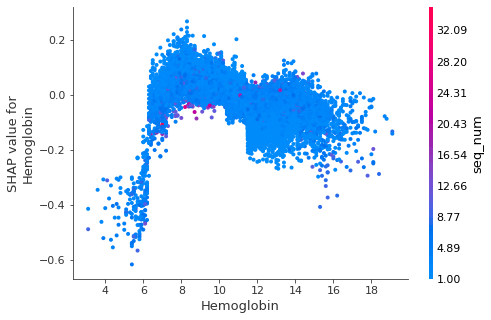

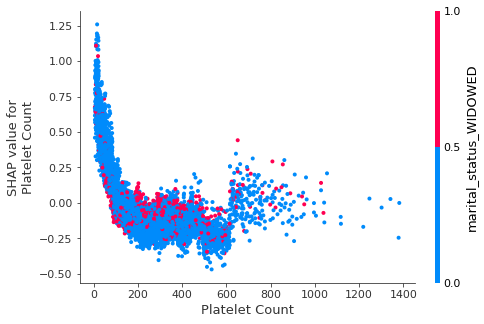

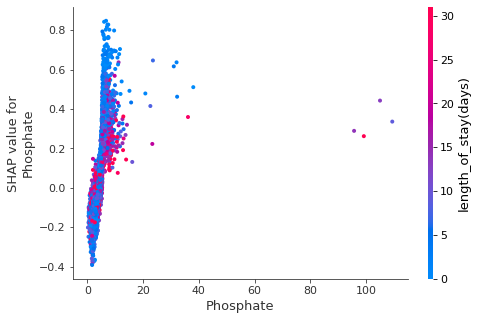

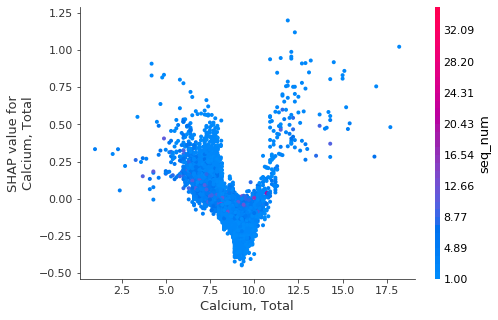

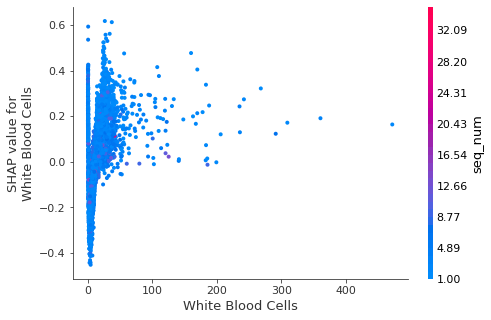

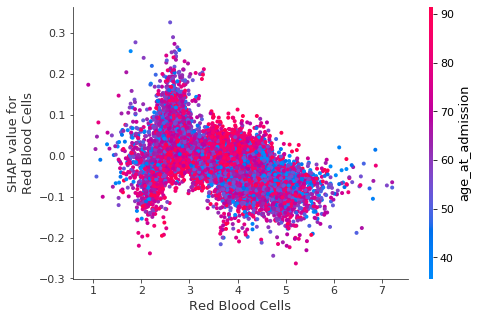

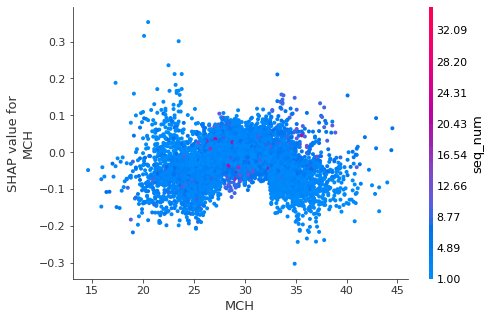

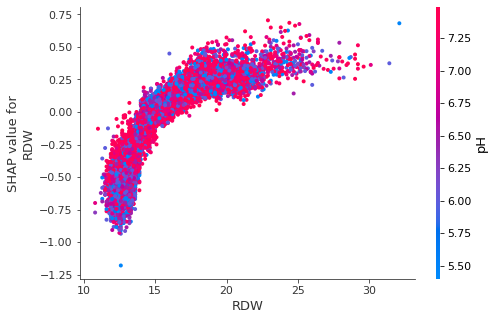

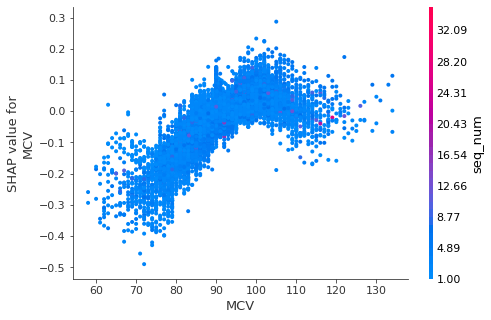

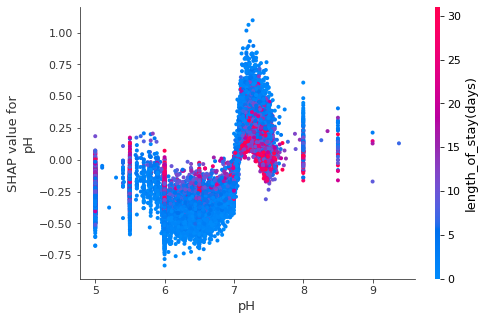

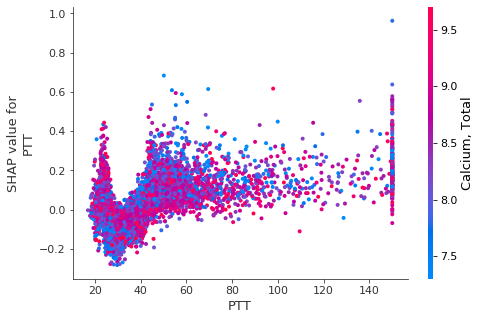

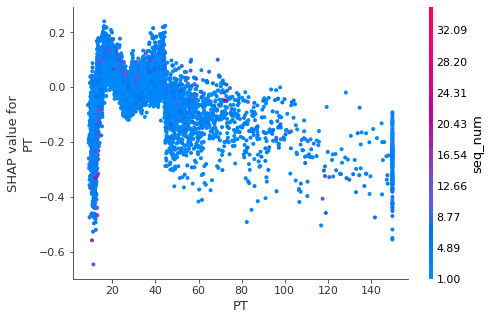

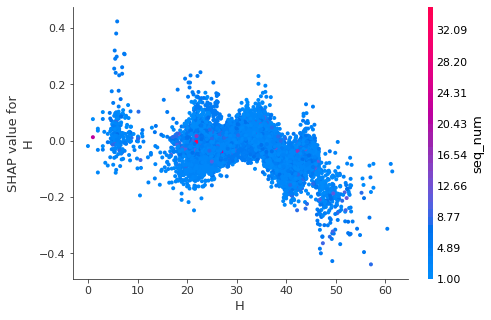

In [8]:
shap_values = explainer.shap_values( X_no_cat)
shap.summary_plot(shap_values,X_no_cat ,feature_names=feature_names)
for predictor in feature_names:
    if predictor not in cat_feature_names:
        shap.dependence_plot(predictor, shap_values,X_no_cat ,feature_names=feature_names)

# CatBoost

In [9]:
CB_classifier = CatBoostClassifier(
     verbose=False,
     early_stopping_rounds=50,
)
CB_params = {
        'catboostclassifier__learning_rate': [0.05, 0.1],
        'catboostclassifier__depth': [4,5,6,7,8,9],
        'catboostclassifier__l2_leaf_reg': [1, 3, 5, 7, 8],
        'catboostclassifier__scale_pos_weight': [0.5,0.75,0.9,1, 1.1, 1.25,1.5]

} 
# Note Attention: (ignore, affects speed(not result quality))
# Do not use one-hot encoding during preprocessing. This affects both the training speed and the resulting quality.
# Note that using SMOTENC doesn't work with catboost as it requires int and it by default converts to int
model = strat_cv_it(CB_classifier ,CB_params,True,25)['catboostclassifier']
explainer = shap.TreeExplainer(model)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  8.8min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed: 24.2min finished


0.8273499344937537

{'catboostclassifier__scale_pos_weight': 0.5,
 'catboostclassifier__learning_rate': 0.05,
 'catboostclassifier__l2_leaf_reg': 8,
 'catboostclassifier__depth': 6}

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       45.603338      3.398646         0.554516        0.162399   
1      105.442258      2.285033         0.620673        0.129029   
2       52.890841      1.511110         0.581112        0.157445   
3      172.274803      0.460666         0.642614        0.046526   
4      161.694108      7.449311         0.488028        0.102090   
5       44.890576      0.137274         0.641284        0.109534   
6       46.244954      0.498573         0.568147        0.091277   
7       40.205443      0.828410         0.548865        0.086034   
8       35.866717      2.767142         0.533240        0.219571   
9       40.336094      0.881817         0.629981        0.225997   
10      41.105037      0.849842         0.464757        0.065496   
11      41.975708      0.418750         0.530581        0.215373   
12     165.018216      1.796351         0.653252        0.194586   
13      48.265548      1.215681         0.681178        0.038917   
14     105.744782      2.969469         0.580115        0.103423   
15     163.795154      1.649583         0.672202        0.036408   
16      40.252651      0.428143         0.703119        0.024847   
17      69.983118      3.549816         0.721403        0.128694   
18      53.268165      1.460288         0.515288        0.095987   
19      69.910312      2.459963         0.510302        0.188177   
20      51.873896      5.669112         0.523267        0.215598   
21      70.389031      2.217478         0.598067        0.084910   
22     104.793327      3.270117         0.635634        0.074918   
23      67.643044      4.942091         0.654582        0.181189   
24      33.310887      9.684260         0.424199        0.186250   

   param_catboostclassifier__scale_pos_weight  \
0                                        1.25   
1                                        1.25   
2                                         0.5   
3                                        1.25   
4                                           1   
5                                           1   
6                                         1.5   
7                                         1.1   
8                                         0.9   
9                                         0.9   
10                                        0.5   
11                                          1   
12                                        1.1   
13                                        1.5   
14                                        1.1   
15                                        1.5   
16                                        0.9   
17                                        0.9   
18                                        0.5   
19                                        0.5   
20                                          1   
21                                       0.75   
22                                        1.1   
23                                        1.1   
24                                        1.5   

   param_catboostclassifier__learning_rate  \
0                                     0.05   
1                                      0.1   
2                                      0.1   
3                                     0.05   
4                                      0.1   
5                                     0.05   
6                                     0.05   
7                                      0.1   
8                                     0.05   
9                                     0.05   
10                                    0.05   
11                                     0.1   
12                                    0.05   
13                                    0.05   
14                                    0.05   
15                                    0.05   
16                                     0.1   
17                                     0.1   
18                                    0.05   
19                                     0

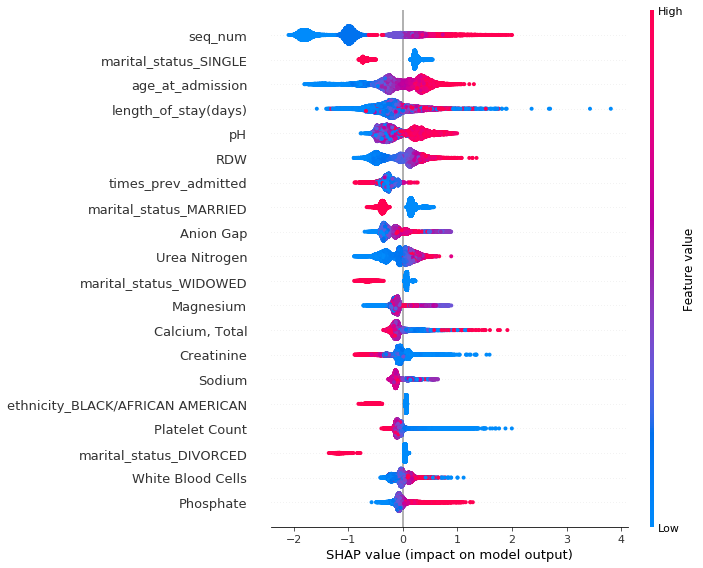

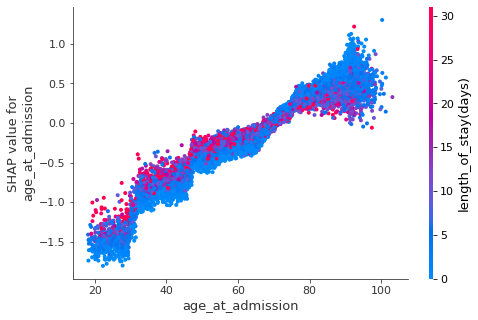

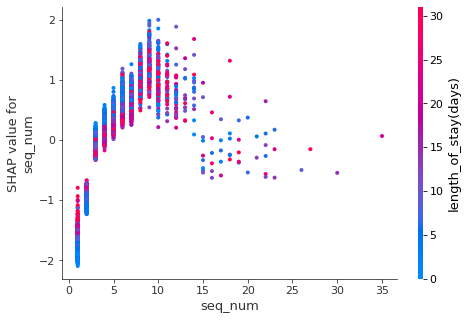

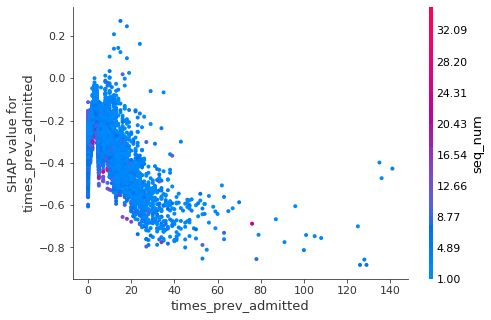

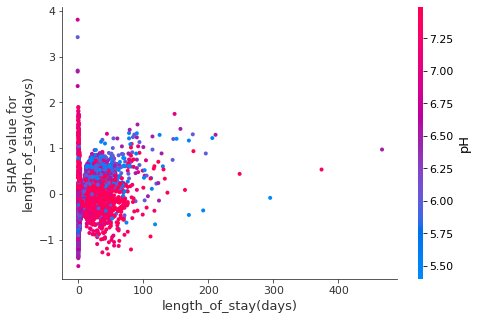

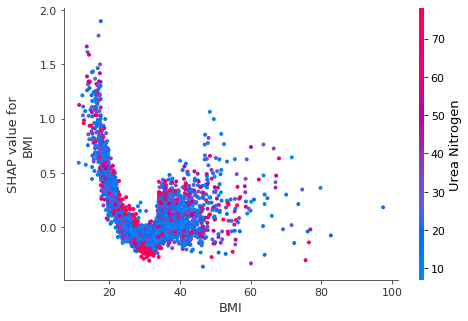

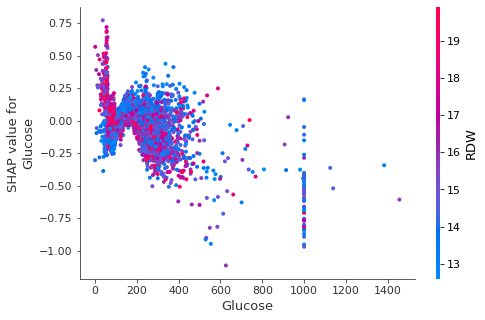

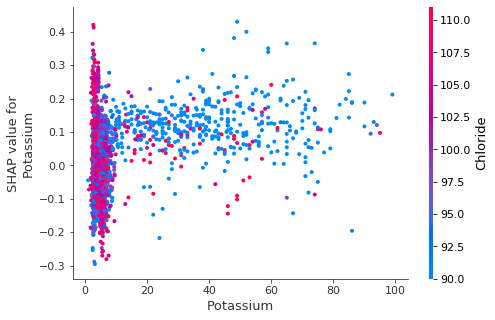

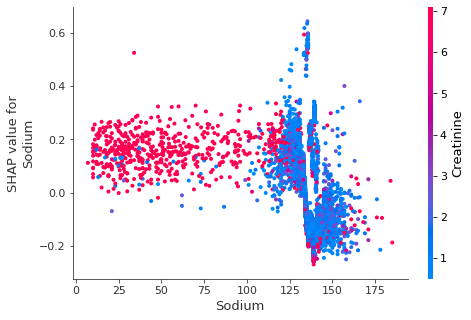

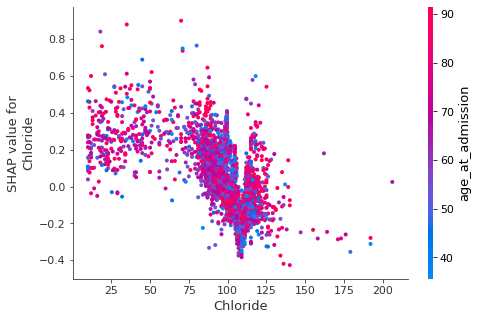

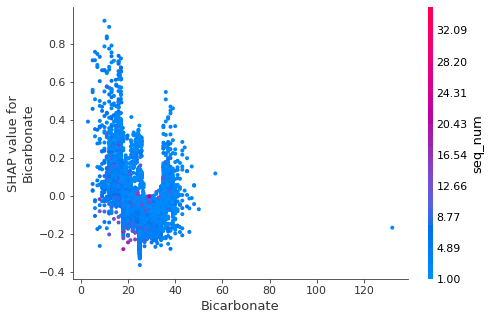

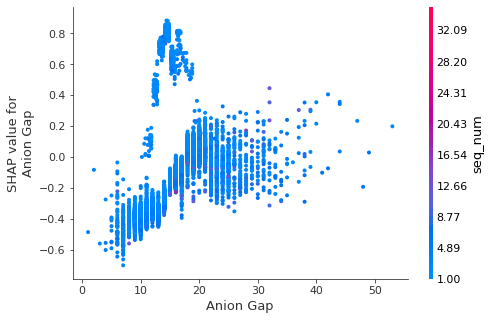

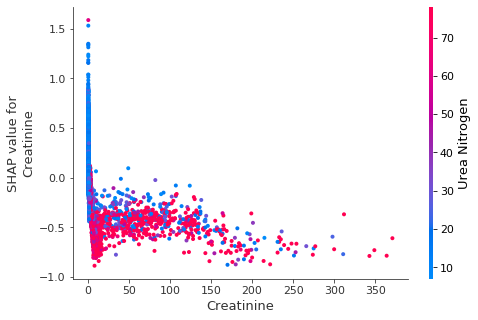

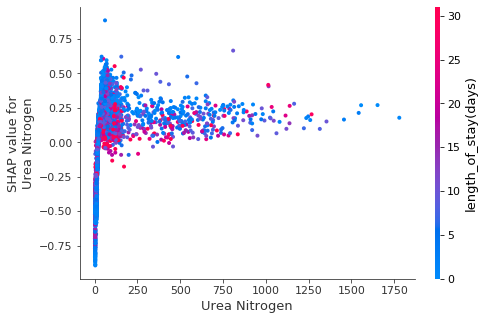

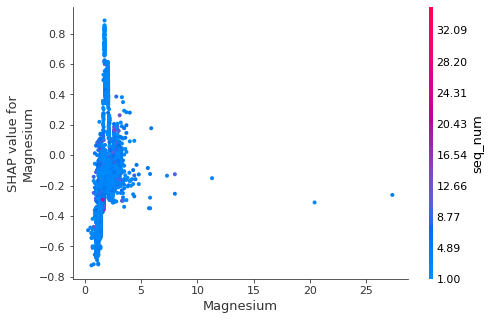

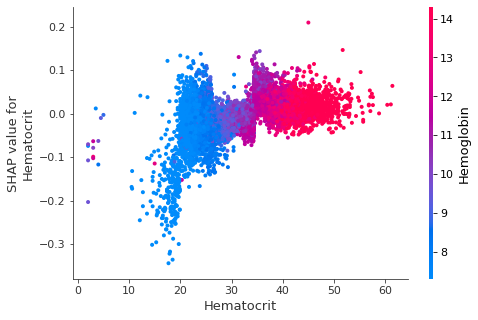

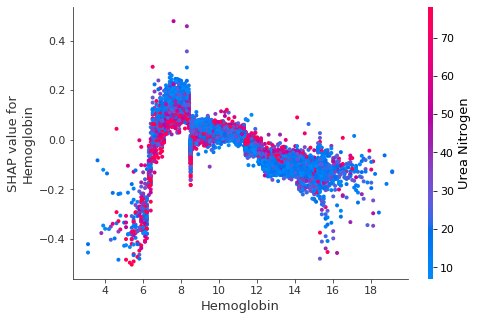

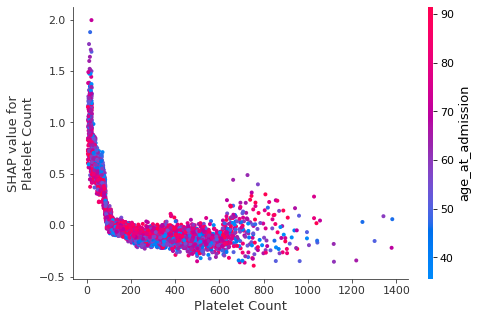

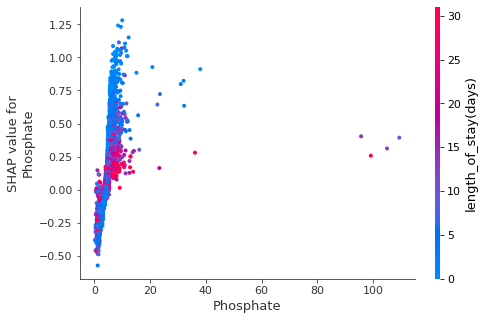

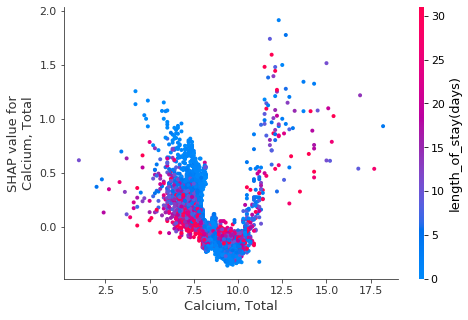

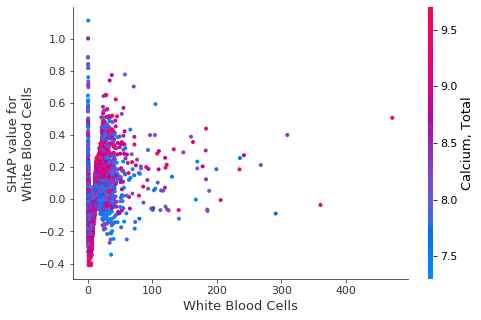

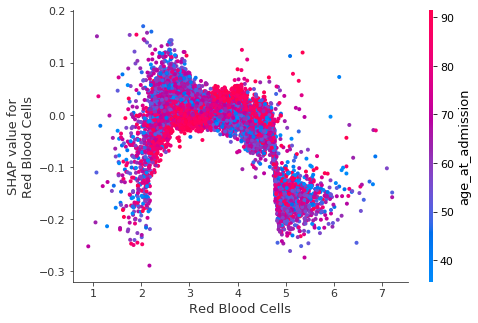

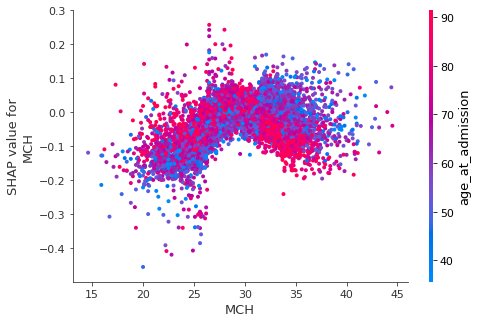

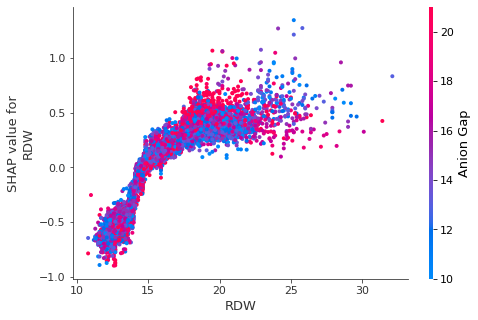

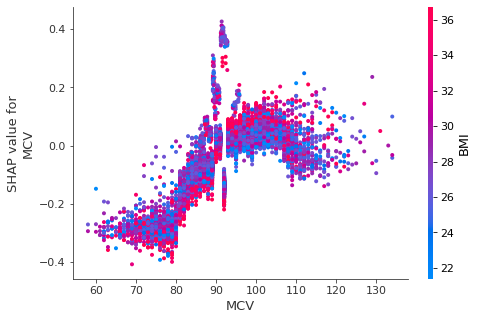

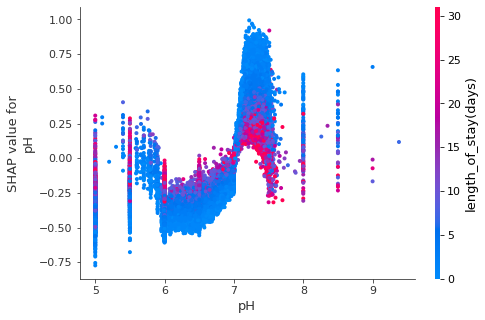

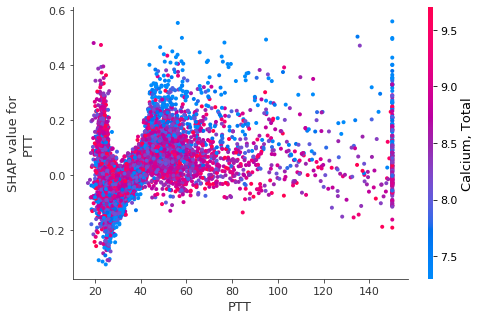

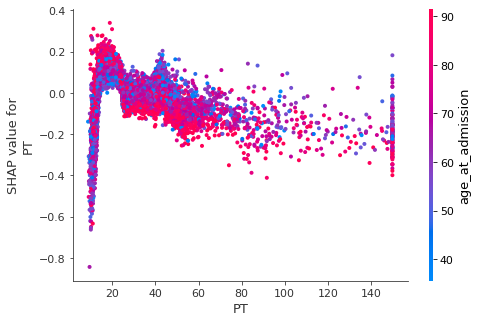

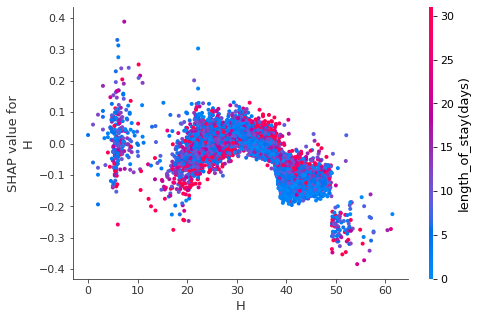

In [10]:
shap_values = explainer.shap_values(dataset_no_target)
shap.summary_plot(shap_values, dataset_no_target ,feature_names=feature_names)
for predictor in feature_names:
    if predictor not in cat_feature_names:
        shap.dependence_plot(predictor, shap_values ,dataset_no_target ,feature_names=feature_names)

# LightGBM

In [11]:
LGB_classifier = lgb.LGBMClassifier()
LGB_params = {
             'lgbmclassifier__num_leaves': [1,5,8,10,15,20,35,40], 
             'lgbmclassifier__min_child_samples': [1,5,10,20,50,100,200,300,400,500], 
             'lgbmclassifier__min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'lgbmclassifier__subsample': [0.2,0,4,0.5, 0.6, 0.8, 1.0],
             'lgbmclassifier__colsample_bytree': [0.6, 0.8, 1.0],
             'lgbmclassifier__reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'lgbmclassifier__reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'lgbmclassifier__scale_pos_weight':  [0.5,0.75,0.9,1, 1.1, 1.25,1.5]

}
model = strat_cv_it(LGB_classifier ,LGB_params,True,50)['lgbmclassifier']
explainer = shap.TreeExplainer(model)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   34.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:  3.3min finished


0.8200563387784311

{'lgbmclassifier__subsample': 0.6,
 'lgbmclassifier__scale_pos_weight': 1.5,
 'lgbmclassifier__reg_lambda': 0,
 'lgbmclassifier__reg_alpha': 0,
 'lgbmclassifier__num_leaves': 20,
 'lgbmclassifier__min_child_weight': 0.001,
 'lgbmclassifier__min_child_samples': 200,
 'lgbmclassifier__colsample_bytree': 0.6}

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        3.612004      0.080623         0.067154    9.438158e-03   
1        4.049168      0.040903         0.097739    1.486040e-02   
2        4.124965      0.010006         0.086103    1.298639e-02   
3        3.163536      0.084356         0.000000    0.000000e+00   
4        3.606019      0.075294         0.084773    2.820973e-03   
5        3.335411      0.046994         0.030252    9.404367e-04   
6        3.675832      0.031119         0.085106    1.111562e-02   
7        3.034216      0.041156         0.000000    0.000000e+00   
8        3.392923      0.039718         0.051862    8.141988e-04   
9        3.632948      0.022365         0.067486    4.484893e-03   
10       3.855353      0.090108         0.097406    1.037500e-02   
11       3.072115      0.077057         0.000000    0.000000e+00   
12       2.977036      0.029327         0.000000    0.000000e+00   
13       3.265597      0.036330         0.030585    1.694983e-03   
14       2.977036      0.021157         0.000000    0.000000e+00   
15       2.966398      0.030189         0.000000    0.000000e+00   
16       2.975374      0.028794         0.000000    0.000000e+00   
17       3.751298      0.120316         0.067819    1.410683e-03   
18       3.113006      0.080334         0.000000    0.000000e+00   
19       3.417857      0.046552         0.051861    1.410290e-03   
20       3.640926      0.050595         0.067819    8.020568e-03   
21       3.576100      0.025393         0.065159    1.244028e-03   
22       3.323110      0.034036         0.032247    1.880368e-03   
23       3.256622      0.033121         0.029920    2.973602e-07   
24       3.421181      0.008476         0.054188    1.880536e-03   
25       3.628958      0.054091         0.065824    1.628300e-03   
26       3.042195      0.048019         0.000000    0.000000e+00   
27       2.952768      0.028447         0.000000    0.000000e+00   
28       3.874635      0.108890         0.098736    5.700281e-03   
29       3.133285      0.068210         0.000000    0.000000e+00   
30       2.970388      0.029251         0.000000    0.000000e+00   
31       3.743651      0.054238         0.064162    1.243454e-03   
32       3.031556      0.048068         0.000000    0.000000e+00   
33       4.278554      0.115193         0.098072    7.115336e-03   
34       3.254294      0.143902         0.000000    0.000000e+00   
35       3.025905      0.010649         0.000000    0.000000e+00   
36       2.964403      0.031542         0.000000    0.000000e+00   
37       3.450769      0.022316         0.064826    1.410515e-03   
38       3.722043      0.011828         0.067819    5.700142e-03   
39       3.075772      0.029931         0.000000    0.000000e+00   
40       3.747973      0.078989         0.093749    1.547238e-02   
41       3.088737      0.086858         0.000000    0.000000e+00   
42       3.572775      0.028377         0.063164    1.243858e-03   
43       3.953091      0.010813         0.114361    1.793951e-02   
44       3.691125      0.070031         0.064827    1.410402e-03   
45       2.997647      0.045033         0.000000    0.000000e+00   
46       2.933486      0.010050         0.000000    0.000000e+00   
47       3.775566      0.068656         0.095744    1.412757e-02   
48       3.163205      0.071481         0.000000    0.000000e+00   
49       3.675500      0.141045         0.095089    2.849108e-03   

   param_lgbmclassifier__subsample param_lgbmclassifier__scale_pos_weight  \
0                              0.2                                    0.5   
1                              0.8                                    0.5   
2                                1                                      1   
3                                1                                    0.9   
4                              0.5                                   1.25   
5                                1                                    0.9

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


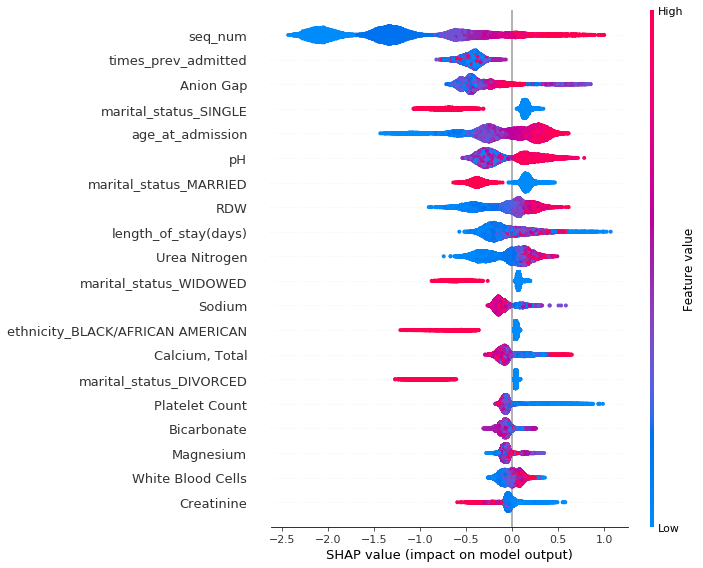

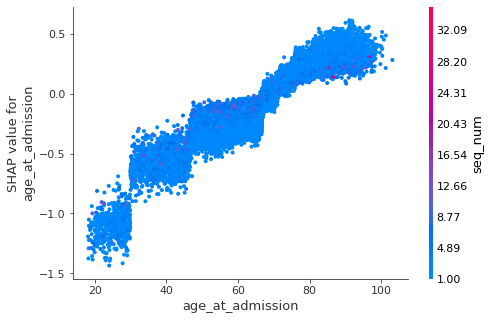

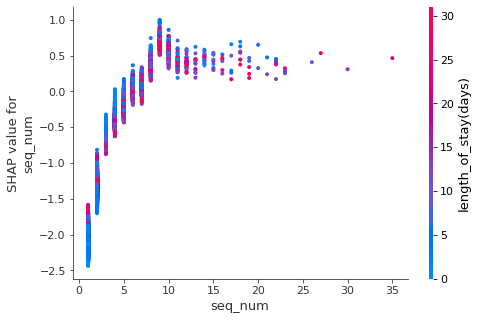

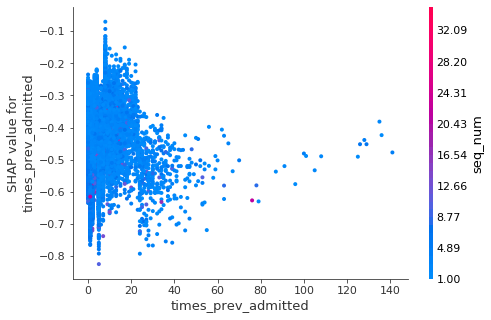

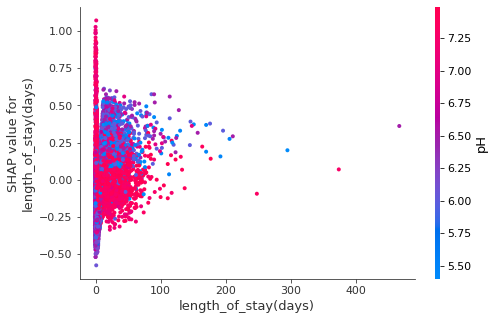

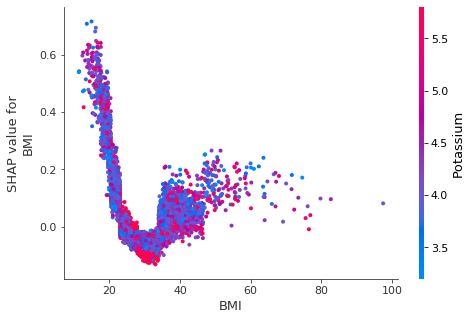

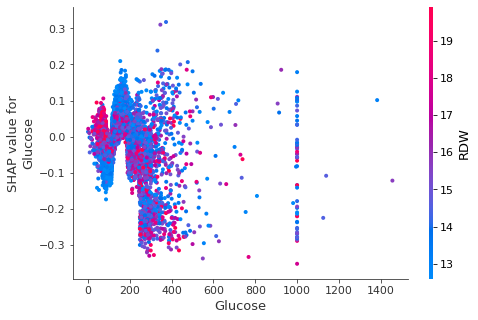

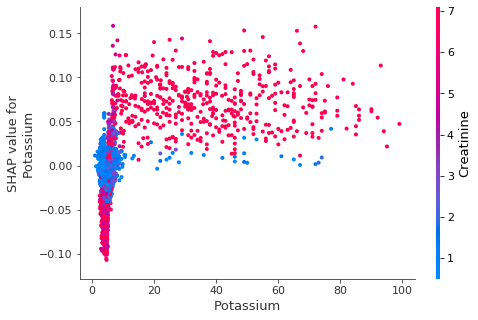

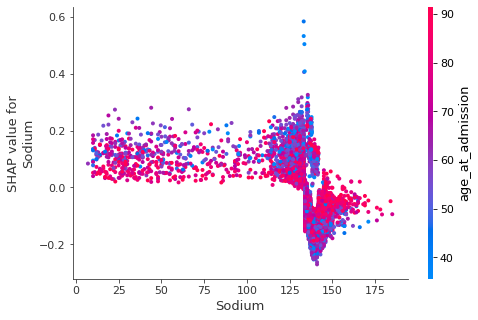

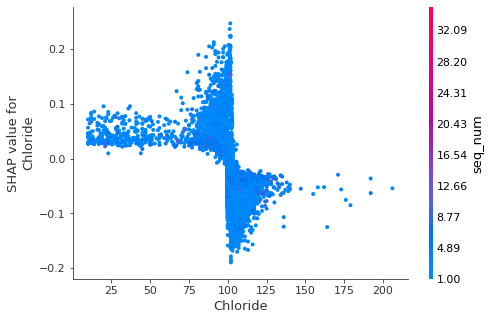

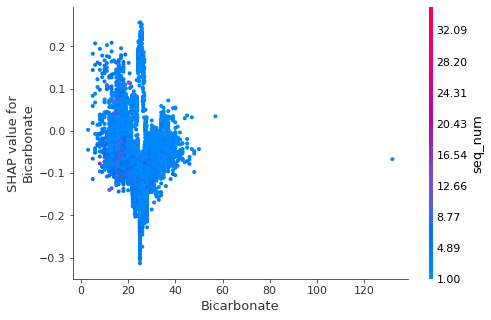

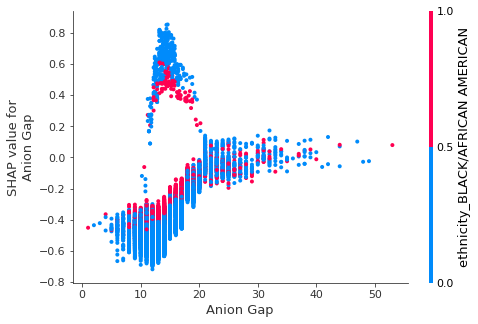

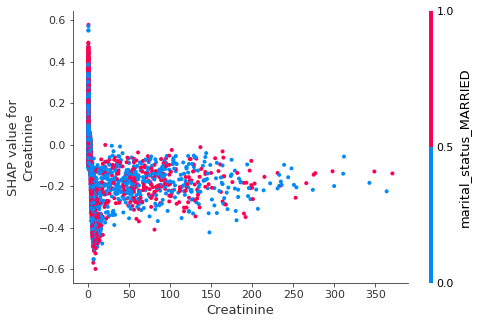

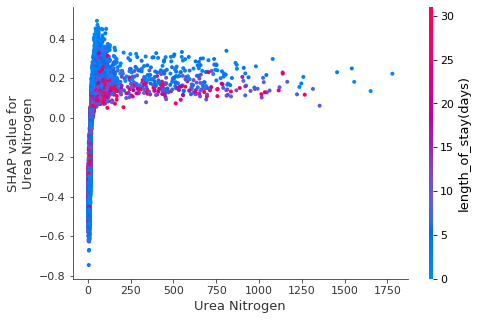

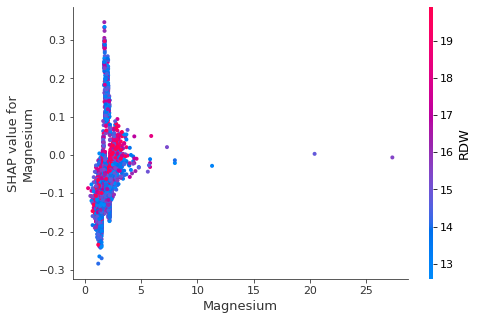

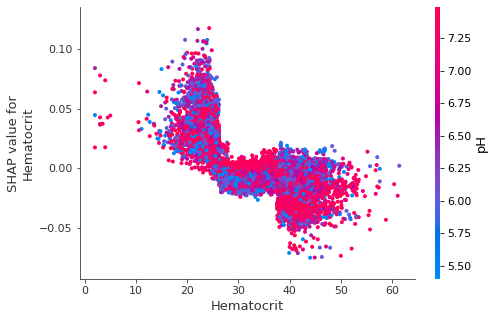

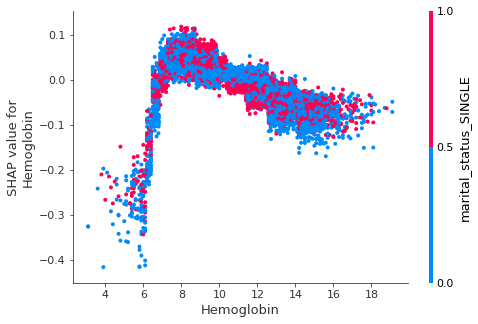

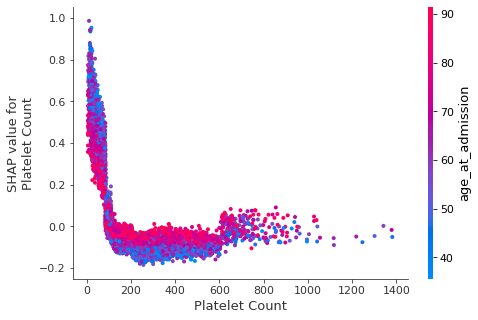

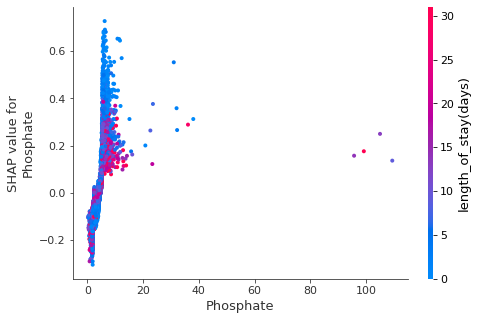

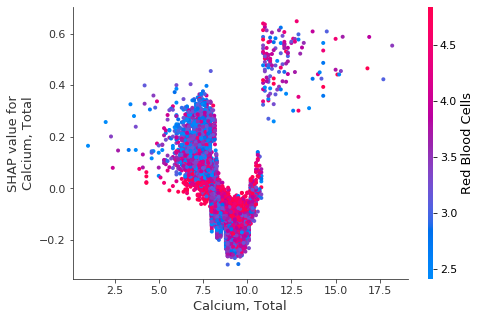

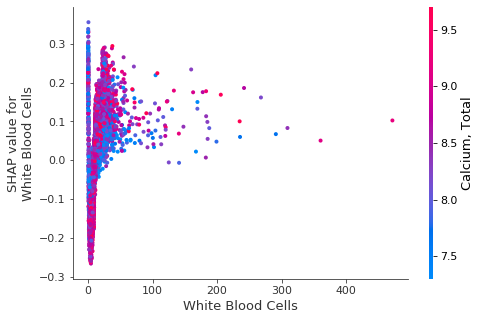

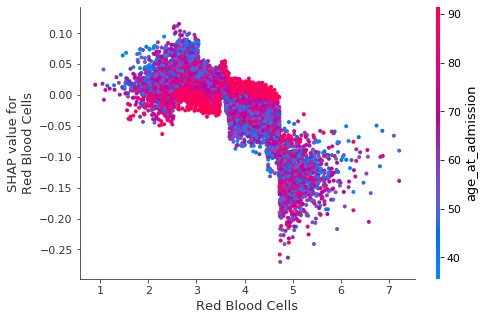

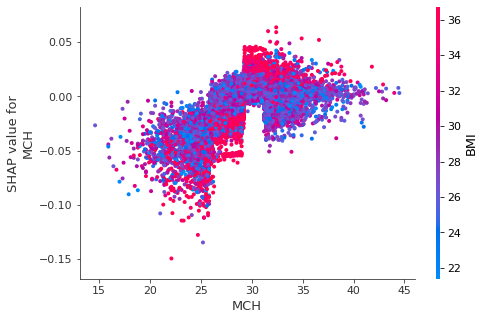

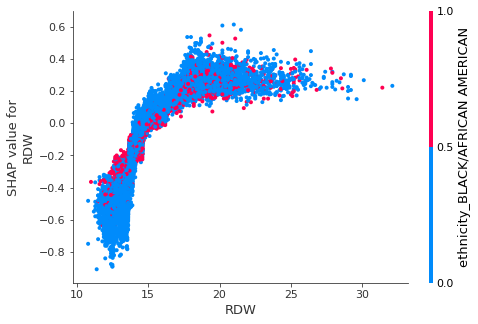

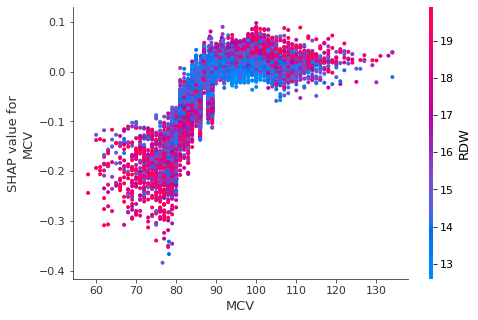

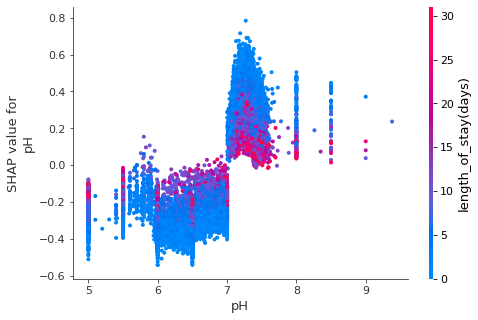

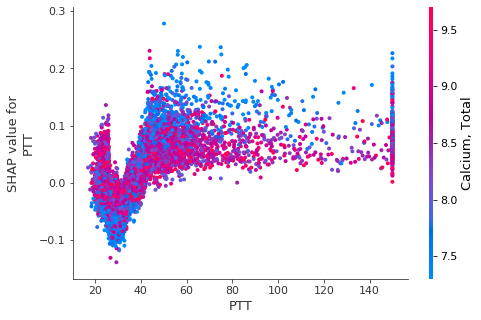

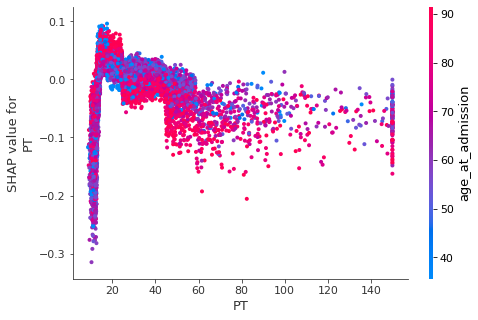

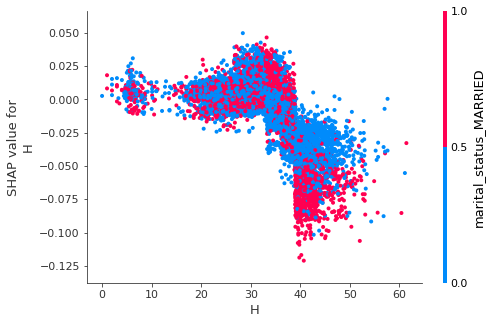

In [12]:
shap_values = explainer.shap_values(dataset_no_target)
shap.summary_plot(shap_values[1], dataset_no_target ,feature_names=feature_names)
for predictor in feature_names:
    if predictor not in cat_feature_names:
        shap.dependence_plot(predictor, shap_values[1] ,dataset_no_target ,feature_names=feature_names)